# **Test Image Classificator models**

To test the project with this file you need to download the saved models from my [OneDrive](https://1drv.ms/f/s!Aq71tucDLoacgrY6NBsA_xuX-6HiUQ?e=uyGmMF). After downloads create ```test``` folder in ```notes``` folder and copy the saved models into them.

In [98]:
# Run to load images
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from pathlib import Path
from tinyimagenet import TinyImageNet

val = TinyImageNet(
    Path("~/.torchvision/tinyimagenet/"),
    split="val",
    imagenet_idx=False,
    transform=transforms.RandomHorizontalFlip(p=0),
)

baseTrasform = transforms.Compose(
    [
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.480, 0.448, 0.398], std=[0.230, 0.226, 0.226]),
    ]
)

transform200 = transforms.Compose(
    [
        transforms.Resize(
            [96, 96],
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        baseTrasform,
    ]
)
transform10 = transforms.Compose(
    [
        transforms.Resize(
            [128, 128],
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        baseTrasform,
    ]
)


def show_images(rows, cols, size, indexes):
    newset = []
    for i in indexes:
        newset.append(val[i][0])
    fig, axes = plt.subplots(rows, cols, figsize=size)

    for i, ax in enumerate(axes.flat):
        ax.imshow(newset[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## **All image classification**

Testing for ResNet101 fine-tuning  with imagenet1k_v1

In [99]:
import sys
import os
import torch

sys.path.append(os.path.abspath("../"))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Model.Testing as test

all_images_model = test.get_nn_architecture(
    type="resnet101",
    num_classes=200,
    fine_tune=True,
    transfer_learning=False,
    dropout_rate_rb=0.3,
    dropout_rate_fc=0.4,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
all_images_model = all_images_model.to(DEVICE)

all_images_model = test.load_model("./test/all_images.pth", all_images_model)

Architecture: pretrained resnet101


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Fine-tune
Dropout rate basicBlock: 0.3, Dropout rate final layer: 0.4
Dropout before the last convolutional layer
Dropout after the average pooling layer


Label:  2
Prediction:  tensor(2, device='cuda:0')


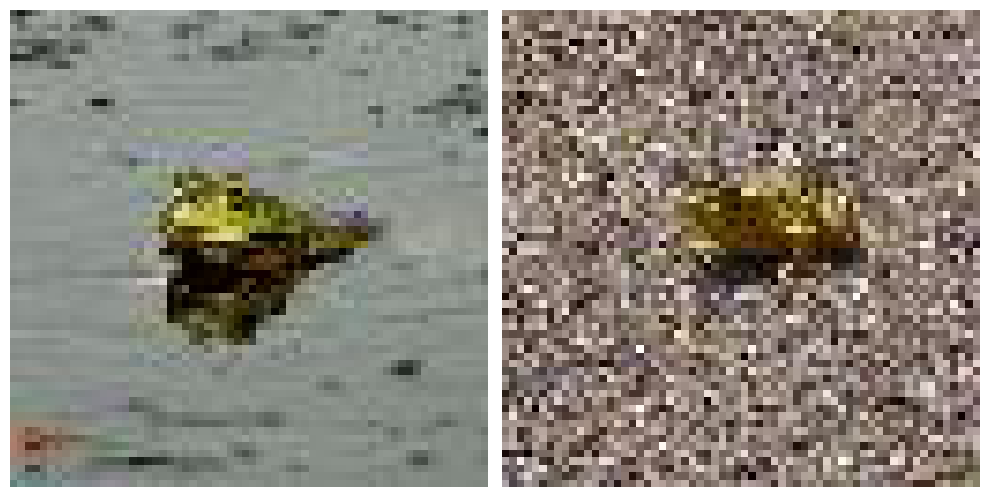

In [120]:
import random

index = random.randint(0, 200)
data = transform200(val[index][0])
# From tensor to int
prediction = test.test_model(all_images_model, data, DEVICE)[0]
print("Label: ", val[index][1])
print("Prediction: ", prediction)

# show image, label and prediction
show_images(1, 2, (10, 10), [index, prediction * 50])

## **Performance between different number of classes**

Step(a): Resnet18 trained from scratch only on class 0 with BCELoss.

In [101]:
only_zero_model = test.get_nn_architecture(
    type="resnet18",
    num_classes=1,
    fine_tune=False,
    transfer_learning=False,
    dropout_rate_rb=0.5,
    dropout_rate_fc=0.6,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
only_zero_model = only_zero_model.to(DEVICE)

only_zero_model = test.load_model("./test/a.pth", only_zero_model)

Architecture: not-pretrained resnet18


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Dropout rate basicBlock: 0.5, Dropout rate final layer: 0.6
Dropout before the last convolutional layer
Dropout after the average pooling layer


tensor([0.9877], device='cuda:0')
Label:  0
Prediction:  tensor(1., device='cuda:0')


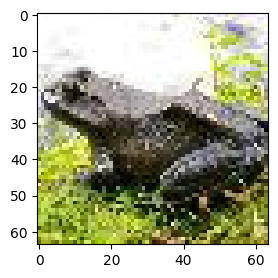

In [114]:
index = random.randint(0, 200)
data = transform10(val[index][0])
# From tensor to int
prediction = test.test_model(only_zero_model, data, DEVICE, oneClass=True)[0]
label = 1 if val[index][1] == 0 else 0
print("Label: ", label)
print("Prediction: ", prediction)

# show image, label and prediction
newset = val[index][0]

plt.figure(figsize=(3, 3))
plt.imshow(newset)

#### Step(b) 

Testing for resnet18 trained from scratch on reference class 0 with 9 randomly select classes with CrossEntropyLoss.

- iteration 1: Resnet18 trained from scratch on classes 143, 89, 35, 155, 47, 159, 81, 101, 84, 0

In [103]:
b1Model = test.get_nn_architecture(
    type="resnet18",
    num_classes=10,
    fine_tune=False,
    transfer_learning=False,
    dropout_rate_rb=0.5,
    dropout_rate_fc=0.6,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
b1Model = b1Model.to(DEVICE)

b1Model = test.load_model("./test/b1.pth", b1Model)

Architecture: not-pretrained resnet18


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Dropout rate basicBlock: 0.5, Dropout rate final layer: 0.6
Dropout before the last convolutional layer
Dropout after the average pooling layer


Label:  35
Prediction:  35


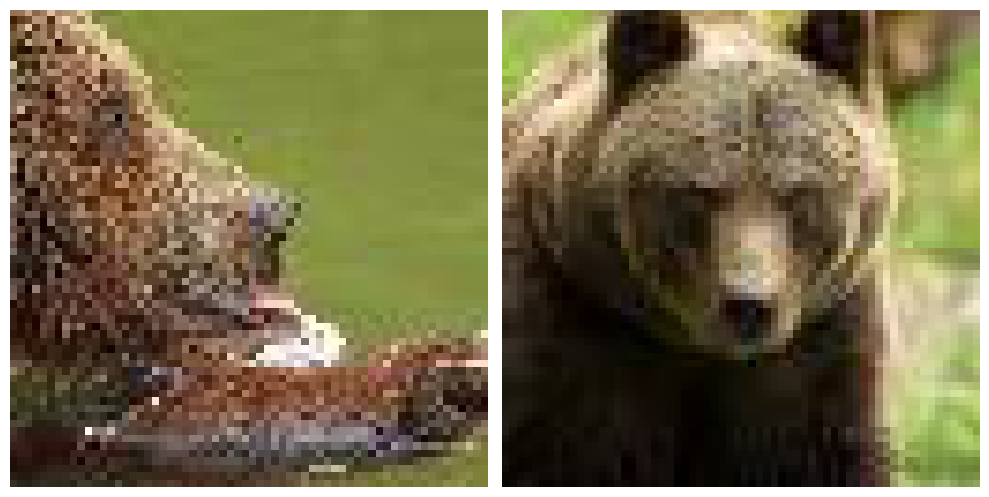

In [112]:
cls = [143, 89, 35, 155, 47, 159, 81, 101, 84, 0]
c = random.choice(cls)
plus = np.random.randint(0, 50)
index = c * 50 + plus

data = transform10(val[index][0])
# From tensor to int
prediction = test.test_model(b1Model, data, DEVICE)[0]
print("Label: ", val[index][1])
print("Prediction: ", cls[prediction])

# show image, label and prediction
show_images(1, 2, (10, 10), [index, cls[prediction] * 50])

- iteration 2: Resnet18 trained from scratch on classes 13, 185, 107, 169, 22, 10, 40, 106, 85, 0

In [105]:
b2Model = test.get_nn_architecture(
    type="resnet18",
    num_classes=10,
    fine_tune=False,
    transfer_learning=False,
    dropout_rate_rb=0.5,
    dropout_rate_fc=0.6,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
b2Model = b2Model.to(DEVICE)

b2Model = test.load_model("./test/b2.pth", b2Model)

Architecture: not-pretrained resnet18


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Dropout rate basicBlock: 0.5, Dropout rate final layer: 0.6
Dropout before the last convolutional layer
Dropout after the average pooling layer


Label:  10
Prediction:  10


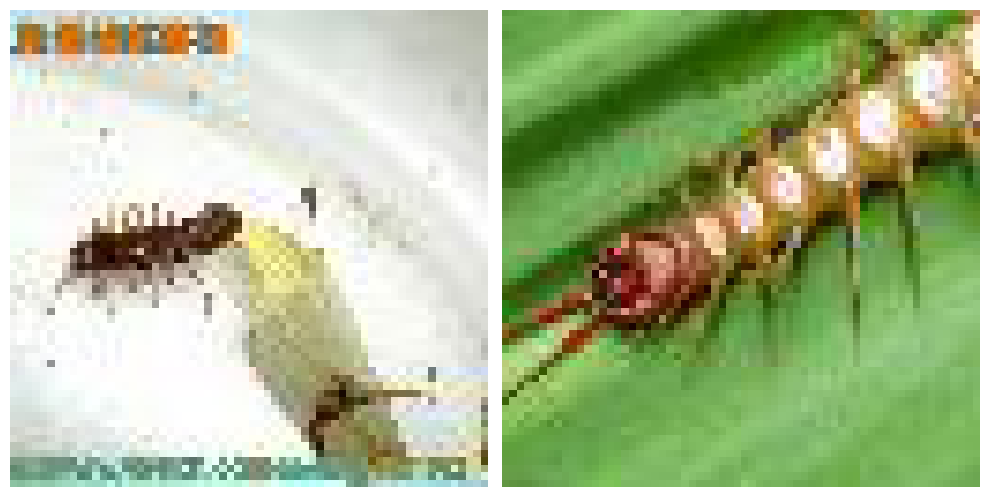

In [111]:
cls = [13, 185, 107, 169, 22, 10, 40, 106, 85, 0]
c = random.choice(cls)
plus = np.random.randint(0, 50)
index = c * 50 + plus

data = transform10(val[index][0])
# From tensor to int
prediction = test.test_model(b2Model, data, DEVICE)[0]
print("Label: ", val[index][1])
print("Prediction: ", cls[prediction])

# show image, label and prediction
show_images(1, 2, (10, 10), [index, cls[prediction] * 50])

- iteration 3: Resnet18 trained from scratch on classes 79, 34, 147, 166, 73, 26, 176, 106, 32, 0

In [107]:
b3Model = test.get_nn_architecture(
    type="resnet18",
    num_classes=10,
    fine_tune=False,
    transfer_learning=False,
    dropout_rate_rb=0.5,
    dropout_rate_fc=0.6,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
b3Model = b3Model.to(DEVICE)

b3Model = test.load_model("./test/b3.pth", b3Model)

Architecture: not-pretrained resnet18


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Dropout rate basicBlock: 0.5, Dropout rate final layer: 0.6
Dropout before the last convolutional layer
Dropout after the average pooling layer


Label:  26
Prediction:  26


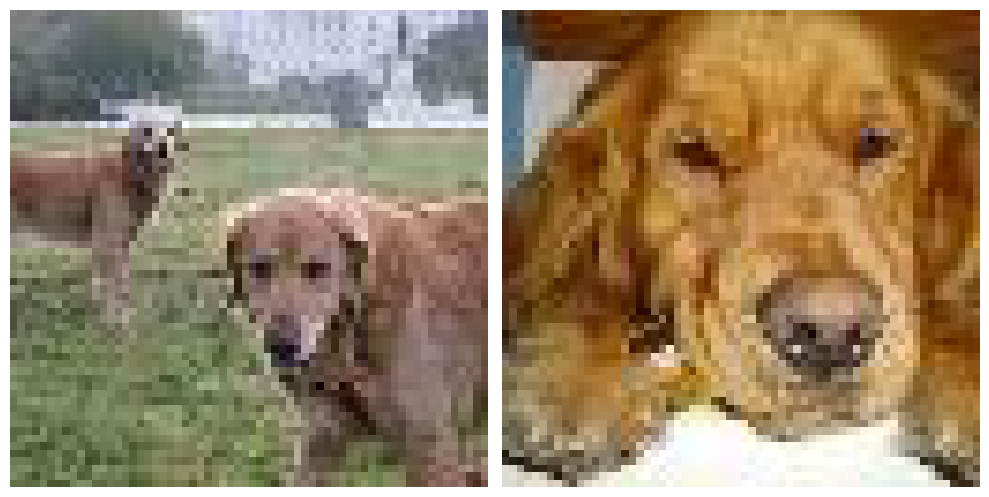

In [108]:
cls = [79, 34, 147, 166, 73, 26, 176, 106, 32, 0]
c = random.choice(cls)
plus = np.random.randint(0, 50)
index = c * 50 + plus

data = transform10(val[index][0])
# From tensor to int
prediction = test.test_model(b3Model, data, DEVICE)[0]
print("Label: ", val[index][1])
print("Prediction: ", cls[prediction])

# show image, label and prediction
show_images(1, 2, (10, 10), [index, cls[prediction] * 50])

#### Step(c)

Resnet18 trained from scratch on classes that we consider closest to the reference class 0.

In [109]:
cModel = test.get_nn_architecture(
    type="resnet18",
    num_classes=10,
    fine_tune=False,
    transfer_learning=False,
    dropout_rate_rb=0.5,
    dropout_rate_fc=0.6,
    dropout_pos_rb=0,
    dropout_pos_fc=1,
)
cModel = cModel.to(DEVICE)

cModel = test.load_model("./test/c.pth", cModel)

Architecture: not-pretrained resnet18


Using cache found in C:\Users\vince/.cache\torch\hub\pytorch_vision_v0.17.0


Dropout rate basicBlock: 0.5, Dropout rate final layer: 0.6
Dropout before the last convolutional layer
Dropout after the average pooling layer


Label:  13
Prediction:  13


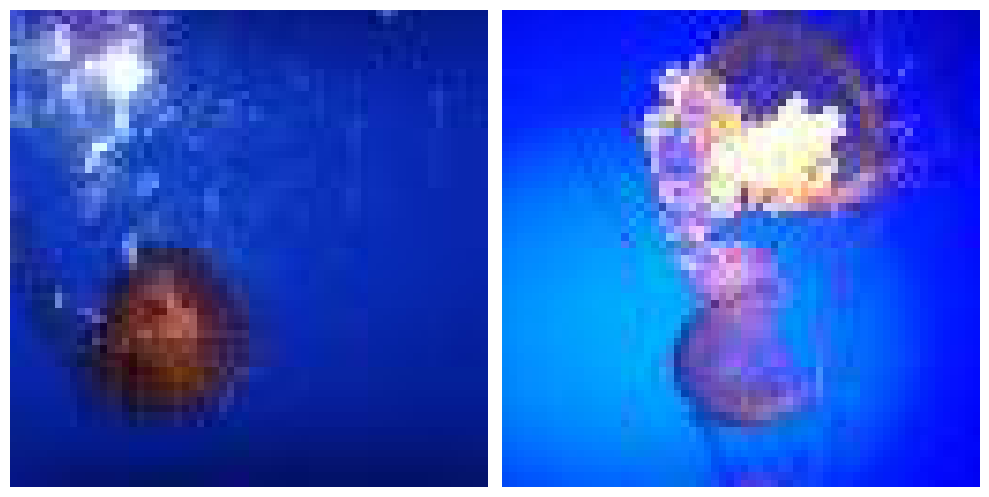

In [110]:
cls = [0, 180, 184, 18, 17, 13, 44, 186, 36, 45]
c = random.choice(cls)
plus = np.random.randint(0, 50)
index = c * 50 + plus

data = transform10(val[index][0])
# From tensor to int
prediction = test.test_model(cModel, data, DEVICE)[0]
print("Label: ", val[index][1])
print("Prediction: ", cls[prediction])

# show image, label and prediction
show_images(1, 2, (10, 10), [index, cls[prediction] * 50])